# ABC-SMC

This example shows you how to perform ABC Sequential Monte Carlo on a time series from the stochastic degradation model.

First we generate some data using the suggested parameters for this model

In [1]:
%load_ext line_profiler

import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load a forward model

model = toy.StochasticDegradationModel()

# Create some toy data
real_parameters = model.suggested_parameters()
times = np.linspace(0, 50, 100)
values = model.simulate(real_parameters, times)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a uniform prior parameter
log_prior = pints.UniformLogPrior(
    [0.0],
    [0.3]
)

# Set the error measure to be used to compare simulated to observed data
error_measure = pints.RootMeanSquaredError(problem)

We can visualize the generated data against the expected data below

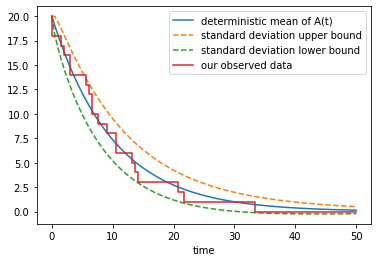

In [2]:
mean = model.mean(real_parameters, times)
variance = model.variance(real_parameters, times)
std_dev = np.sqrt(variance)

plt.plot(times, mean, '-', label = 'deterministic mean of A(t)')
plt.plot(times, mean + std_dev, '--', label = 'standard deviation upper bound')
plt.plot(times, mean - std_dev, '--', label = 'standard deviation lower bound')

plt.step(times, values, label = 'our observed data')
plt.legend(loc = 'upper right')
plt.xlabel('time')
plt.show()

We now create a Sequential ABC Controller, this takes a number of optional parameters but left as default it will carry out the Toni 2019 ABC-SMC sampling algorithm

In [3]:
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)

In [4]:
# set initial threshold
abc.sampler().set_threshold_schedule(np.array([3,1.5,1]))

# produce intermediate distributions of size 200
abc.sampler().set_intermediate_size(200)

# set target number of samples
abc.set_n_target(200)

# log to screen
abc.set_log_to_screen(True)

# %lprun -f abc._calculate_weights 
samples = abc.run()
print('Done!')

Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=1.5
Trying t=2, threshold=1.0
Iter. Eval. Acceptance rate Time m:s
1     1258   0.00079491256    0:05.8
2     1273   0.00157109191    0:05.8
3     1283   0.00233826968    0:05.8
20    1482   0.0134952767     0:06.0
40    1696   0.0235849057     0:06.2
60    2005   0.029925187      0:06.6
80    2195   0.0364464692     0:06.8
100   2467   0.0405350628     0:07.0
120   2718   0.0441501104     0:07.2
140   2989   0.0468384075     0:07.4
160   3364   0.0475624257     0:07.8
180   3678   0.0489396411     0:08.0
200   3978   0.0502765209     0:08.3
Halting: target number of samples (200) reached.
Done!


We can then see how our series of intermediate distributions did at approximating the actual parameters by plotting them as histograms

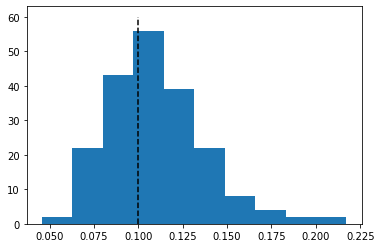

In [10]:
plt.hist([x[0] for x in samples])

plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=60)
plt.show()

Now we can compare the recovered parameters to the real parameters used to generate this data

Observed params: [0.10759993]
Actual params: [0.1]


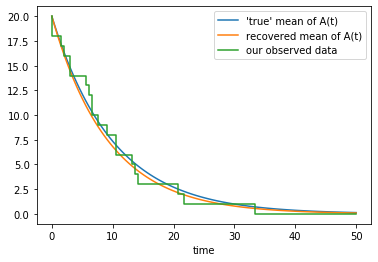

In [11]:
import statistics
observed_k = statistics.median(samples)
print("Observed params: " + str(observed_k))
print("Actual params: " + str(model.suggested_parameters()))
observed_mean = model.mean(observed_k, times)
true_mean = model.mean(model.suggested_parameters(),times)

plt.plot(times, true_mean, '-', label = "'true' mean of A(t)")
plt.plot(times, observed_mean, '-', label = 'recovered mean of A(t)')
plt.step(times, values, label = 'our observed data')
plt.legend(loc = 'upper right')
plt.xlabel('time')
plt.show()

Compare this to using normal ABC-Rejection

In [12]:
abc = pints.ABCController(error_measure, log_prior, pints.RejectionABC)
# set threshold
abc.sampler().set_threshold(1)

# set target number of samples
abc.set_n_target(200)
# log to screen
abc.set_log_to_screen(True)

samples = abc.run()
print('Done!')

Using Rejection ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     88     0.0113636364     0:00.1
2     94     0.0212765957     0:00.1
3     107    0.0280373832     0:00.1
20    559    0.0357781753     0:00.3
40    1214   0.0329489292     0:00.6
60    1728   0.0347222222     0:00.9
80    2263   0.0353513036     0:01.1
100   2683   0.0372717108     0:01.3
120   3337   0.0359604435     0:01.5
140   4062   0.0344657804     0:01.8
160   4678   0.0342026507     0:02.0
180   5015   0.035892323      0:02.1
200   5624   0.0355618777     0:02.4
Halting: target number of samples (200) reached.
Done!


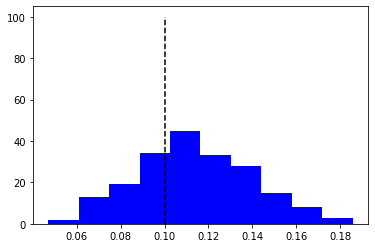

In [13]:
plt.hist(samples[:,0], color="blue")
plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=100)
plt.show()